# Homework #11:
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 10/22/2019|
|Updated | 10/24/2019|

## 21.6 Machine Learning I
### "One Rule" Algorithm (OneR)
Let's first load in and display the famous _iris flower set data_.

In [1]:
from sklearn.datasets import load_iris
from collections import OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

att = ['Sepal Length',
              'Sepal Width',
              'Petal Length',
              'Petal Width']

dataset = load_iris()
X = dataset.data
Y = dataset.target
iris_data = OrderedDict({att[0]: X[:,0],
                         att[1]: X[:,1],
                         att[2]: X[:,2],
                         att[3]: X[:,3],
                         'Label': Y})
df = pd.DataFrame(iris_data)
#pd.set_option('display.max_rows', None) # uncomment to see untruncated dataframe
pd.set_option('display.max_rows', 10)
pd.options.display.float_format = '{:,.1f}'.format
df

,Sepal Length,Sepal Width,Petal Length,Petal Width,Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


### Discretization
In order to establish any "rules," we first need to reduce this more or less _continuous_ data into _discrete_ sets. For each property (e.g., sepal length), we need to separate the species into their own _exclusive_ range of values, or "bin." The resulting _rule_ is such that, e.g., if the sepal length of a new flower falls within one of these three bins (i.e., range of values), then we'll classify it accordingly.

_Optimal binning_ is a data analysis problem in its own right. However, for our purposes, we can start off by finding the mean value of each property—for each species—which we can then use as their respective "bin centers." Let's start with sepal length. Luckily, our data is already grouped by species: the first 50 instances are _setosa_, the middle 50 are _versicolor_ and the last 50 are _virginica_. 

In [2]:
def rule(a):
    """
    Returns rule values based on optimal bin edges derived
    from a species' mean value for a given attribute.
    
    Parameters
    ----------
    a : array_like
        Array containing attribute values grouped by species
    
    Returns
    -------
    edges : array_like
        Array containing rule values based on bin edges
    """
    means = [] # hold attribute means for each species
    means.append(np.mean(a[:50]))     # setosa
    means.append(np.mean(a[50:100]))  # versicolor
    means.append(np.mean(a[100:150])) # virginica
    # take the average value between means to be edges
    edges = [(means[0] + (means[1] - means[0])/2),
             (means[1] + (means[2] - means[1])/2)]
    # correct for cases where edges are decreasing
    if edges[0] > edges[1]:
        temp = edges[0]
        edges[0] = edges[1]
        edges[1] = temp
    return edges

def freqs(a, rule):
    """
    Returns rule-based predictor frequencies.
    
    Parameters
    ----------
    a : array_like
        Array containing attribute values grouped by species
    rule : array_like
        Array containing rule values based on bin edges used
        to calculate frequencies.
    
    Returns
    -------
    table : array_like
        Array containing frequencies of 'rule' applied to 'a'
    """
    bins = np.zeros([3,3]) # hold bin counts
    counts = np.zeros(3)
    start, end = 0, 50

    for i in range(3): # for each species
        counts[0] = np.where(a[start:end] < rule[0])[0].size
        counts[2] = np.where(a[start:end] >= rule[1])[0].size
        counts[1] = np.where(a[start:end] >= rule[0])[0].size - counts[2]
        bins[i,:] = counts
        start += 50
        end += 50
        
    return bins

In [3]:
# Determine rule for sepal length and calculate frequencies
sl_rule = rule(X[:,0])
sl_bins = freqs(X[:,0], sl_rule)

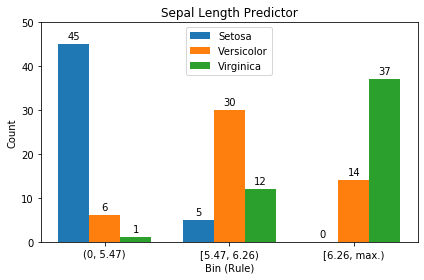

In [4]:
labels = ['(0, '+f'{sl_rule[0]:.2f}'+')',
         '['+f'{sl_rule[0]:.2f}'+', '+f'{sl_rule[1]:.2f}'+')',
         '['+f'{sl_rule[1]:.2f}'+', max.)']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, sl_bins[0,:], width, label='Setosa')
rects2 = ax.bar(x,         sl_bins[1,:], width, label='Versicolor')
rects3 = ax.bar(x + width, sl_bins[2,:], width, label='Virginica')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Sepal Length Predictor')
ax.set_xlabel('Bin (Rule)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Count')
ax.set_ylim(0,50)
ax.legend(loc='upper center')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.0f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
                
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
fig.tight_layout()
plt.show()

### Frequency Tables
If we repeat the process above for the other three flower attributes, we can generate frequency tables that indicate the success rate of each rule. 

In [5]:
def freq_table(a, rule, prop):
    """
    Displays frequency table formated in an ordered dictionary
    with Pandas.
    
    Parameters
    ----------
    a : array_like
        Array containing frequencies
    rule : array_like
        Array containing rule values based on bin edges used
        to calculate frequencies.
    att : string
        String containing the predictor (attribute)
        
    Returns
    -------
    Pandas Data Frame
    """
    labels = ['(0, '+f'{rule[0]:.2f}'+')',
              '['+f'{rule[0]:.2f}'+', '+f'{rule[1]:.2f}'+')',
              '['+f'{rule[1]:.2f}'+', max.)']
    data = OrderedDict({prop: labels,
                        'Setosa': a[:,0],
                        'Versicolor': a[:,1],
                        'Virginica': a[:,2],})
    pd.options.display.float_format = '{:,.0f}'.format
    return pd.DataFrame(data)

In [6]:
freq_table(sl_bins, sl_rule, att[0])

,Sepal Length,Setosa,Versicolor,Virginica
0,"(0, 5.47)",45,5,0
1,"[5.47, 6.26)",6,30,14
2,"[6.26, max.)",1,12,37


In [7]:
sw_rule = rule(X[:,1])
sw_bins = freqs(X[:,1], sw_rule)
freq_table(sw_bins, sw_rule, att[1])

,Sepal Width,Setosa,Versicolor,Virginica
0,"(0, 2.87)",1,7,42
1,"[2.87, 3.10)",27,15,8
2,"[3.10, max.)",19,14,17


In [8]:
pl_rule = rule(X[:,2])
pl_bins = freqs(X[:,2], pl_rule)
freq_table(pl_bins, pl_rule, att[2])

,Petal Length,Setosa,Versicolor,Virginica
0,"(0, 2.86)",50,0,0
1,"[2.86, 4.91)",0,48,2
2,"[4.91, max.)",0,6,44


In [9]:
pw_rule = rule(X[:,3])
pw_bins = freqs(X[:,3], pw_rule)
freq_table(pw_bins, pw_rule, att[3])

,Petal Width,Setosa,Versicolor,Virginica
0,"(0, 0.79)",50,0,0
1,"[0.79, 1.68)",0,48,2
2,"[1.68, max.)",0,4,46


### Accuracy
With the frequency tables in hand, let's now calculate the accuracy of each predictor, or _single rule_.

In [10]:
def acc(a):
    """
    Calculates and returns the accuracy of a rule-based
    frequency table for a particular predictor
    
    Parameters
    ----------
    a : array_like
        Array containing rule-based frequencies by species
    
    Returns
    -------
    accuracy : float
        Percentage accuracy of predictor classification
    """
    return np.amax(a, axis=1).sum() / a.sum()

In [11]:
results = np.asarray([acc(sl_bins),
                      acc(sw_bins),
                      acc(pl_bins),
                      acc(pw_bins)])
accuracies = OrderedDict({'Predictor': att,
                            'Accuracy': results*100,})
pd.options.display.float_format = '{:,.2f} %'.format
pd.DataFrame(accuracies)

,Predictor,Accuracy
0,Sepal Length,74.67 %
1,Sepal Width,58.67 %
2,Petal Length,94.67 %
3,Petal Width,96.00 %


As we can see, ___petal width___ alone is the single best predictor for classification—the ___one rule___.

## 22.5 Machine Learning II
### Workflow
Our ML workflow begins with loading the data. I've chosen a "letter recognition" dataset, comprised of 20,000 instances of 16 integer attributes, for our _classification_ task. Specifically:

* _"The objective is to identify each of a large number of black-and-white rectangular pixel displays as one of the 26 capital letters in the English alphabet. The character images were based on 20 different fonts and each letter within these 20 fonts was randomly distorted to produce a file of 20,000 unique stimuli. Each stimulus was converted into 16 primitive numerical attributes (statistical moments and edge counts) which were then scaled to fit into a range of integer values from 0 through 15."_ ([Source](http://archive.ics.uci.edu/ml/datasets/Letter+Recognition))

In [12]:
data = np.loadtxt("hw11/letter-recognition.data",
                  dtype=int,
                  delimiter=",",
                  usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16)) # Skip the first col containing target data
target = np.loadtxt("hw11/letter-recognition.data",
                    dtype=str, # Contains capital letters, e.g. "A"
                    delimiter=",",
                    usecols=0)

### Split Data

In [13]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(data, target)

### k-Nearest Neighbors Algorithm (k-NN)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier()
estimator.fit(data_train, target_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [15]:
target_pred = estimator.predict(data_test)
accuracy = np.mean(target_test == target_pred)*100
print("Accuracy: {0:.1f} %".format(accuracy))

Accuracy: 95.0 %


### Cross Vaildation

In [16]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator, data, target, scoring='accuracy', cv=5)
average_accuracy = np.mean(scores)*100
print("Average accuracy: {0:.1f}%".format(average_accuracy))

Average accuracy: 95.2%


### Parameters

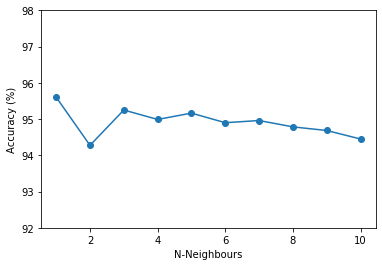

In [17]:
avg_scores = []
all_scores = []
parameters = list(range(1,11))

for n_neighbors in parameters:
    estimator = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_val_score(estimator, data, target, scoring = 'accuracy', cv=5)
    avg_scores.append(np.mean(scores))
    accuracies = np.asarray(avg_scores)*100
    all_scores.append(scores)
    
plt.plot(parameters, accuracies, '-o')
plt.xlabel('N-Neighbours')
plt.ylabel('Accuracy (%)')
plt.ylim([92,98])
plt.show()

Interestingly, for this particular dataset, simply calculating the _nearest, single_ neighbor for classification produces the most accurate reults.